## 1. Setting up Libraries and Imports

In [ ]:
# Import libraries for data manipulation, visualization, and NLP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import time
from imblearn.over_sampling import RandomOverSampler

In [3]:
# Import libraries for machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, f1_score

In [4]:
# Import PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re

In [5]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 2. Data Loading and Preprocessing

In [ ]:
df = pd.read_csv('../data/labeled_data.csv')

In [7]:
print("Dataset Shape:", df.shape)

Dataset Shape: (24783, 7)


In [8]:
print("\nColumns:", df.columns.tolist())


Columns: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet']


In [9]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [10]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64


In [11]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [12]:
class_counts = df['class'].value_counts()
class_percentages = df['class'].value_counts(normalize=True) * 100

print("\nClass Counts:")
print(class_counts)
print("\nClass Percentages:")
print(class_percentages)


Class Counts:
class
1    19190
2     4163
0     1430
Name: count, dtype: int64

Class Percentages:
class
1    77.432111
2    16.797805
0     5.770084
Name: proportion, dtype: float64


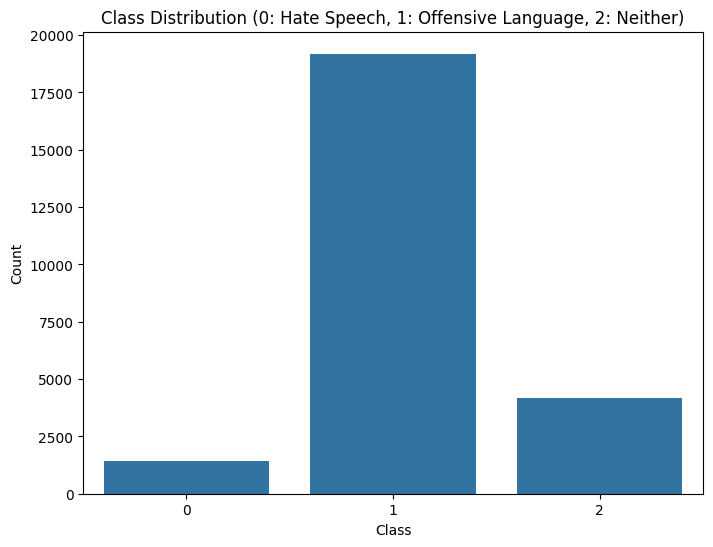

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df)
plt.title('Class Distribution (0: Hate Speech, 1: Offensive Language, 2: Neither)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [14]:
# Keep only the relevant columns: 'class' and 'tweet'
df = df[['class', 'tweet']]

In [15]:
import re

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (just remove # symbol, keep the word if useful)
    text = re.sub(r'#', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function
df['cleaned_tweet'] = df['tweet'].apply(clean_text)

In [16]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

df['cleaned_tweet'] = df['cleaned_tweet'].apply(remove_stopwords)

In [17]:
stemmer = PorterStemmer()

def stem_text(text):
    tokens = text.split()
    stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed)

df['cleaned_tweet'] = df['cleaned_tweet'].apply(stem_text)

In [18]:
df

,class,tweet,cleaned_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt woman shouldnt complain clean hous amp man ...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dat coldtyga dwn bad cuffin dat hoe st ...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt ever fuck bitch start cri confus shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt look like tranni
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shit hear might true might faker bitch told ya
...,...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,you muthafin lie right tl trash mine bibl scri...
24779,2,"you've gone and broke the wrong heart baby, an...",youv gone broke wrong heart babi drove redneck...
24780,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like aint fuck...
24781,1,youu got wild bitches tellin you lies,youu got wild bitch tellin lie


## 3. Train-Test-Split, Vectorization and Oversampling

In [19]:
# Features and labels
X = df['cleaned_tweet']
y = df['class']

# Stratified train-test split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
print("Training Data Shape:", X_train.shape, y_train.shape)
print("Testing Data Shape:", X_test.shape, y_test.shape)

Training Data Shape: (19826,) (19826,)
Testing Data Shape: (4957,) (4957,)


In [21]:
# Initialize the vectorizer
vectorizer = CountVectorizer(max_features=5000)

# Fit on training data and transform both train and test sets
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [22]:
print("Training Data Vectorized Shape:", X_train_vec.shape,y_train.shape)
print("Testing Data Vectorized Shape:", X_test_vec.shape,y_test.shape)

Training Data Vectorized Shape: (19826, 5000) (19826,)
Testing Data Vectorized Shape: (4957, 5000) (4957,)


In [23]:
# Apply oversampling to training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vec, y_train)

# Show class distribution before oversampling
print("Before Oversampling:")
print(pd.Series(y_train).value_counts())

# Show class distribution after oversampling
print("After Oversampling:")
print(pd.Series(y_train_resampled).value_counts())

Before Oversampling:
class
1    15352
2     3330
0     1144
Name: count, dtype: int64
After Oversampling:
class
1    15352
2    15352
0    15352
Name: count, dtype: int64


## 4. Training and Evaluating Machine Learning Models

In [ ]:
# Define all models
lr = LogisticRegression(max_iter=1000)
nb = MultinomialNB()
svm = SVC(kernel='linear', probability=True)
voting = VotingClassifier(estimators=[
    ('lr', lr), ('nb', nb), ('svm', svm)], voting='soft')
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Model dictionary
models = {
    'Logistic Regression': lr,
    'Naive Bayes': nb,
    'SVM': svm,
    'Voting Ensemble': voting,
    'XGBoost': xgb
}

# To store evaluation metrics
metrics = []

# Train and evaluate
for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    metrics.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    print(f"\n{name} Accuracy: {acc:.4f}")
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Hate Speech', 'Offensive', 'Neither']))

# Convert to DataFrame for plotting
metrics_df = pd.DataFrame(metrics)
print("\nSummary of Evaluation Metrics:")
print(metrics_df)


Training: Logistic Regression

Logistic Regression Accuracy: 0.8550
Logistic Regression Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.29      0.55      0.38       286
   Offensive       0.95      0.87      0.91      3838
     Neither       0.81      0.91      0.86       833

    accuracy                           0.85      4957
   macro avg       0.69      0.78      0.72      4957
weighted avg       0.89      0.85      0.87      4957


Training: Naive Bayes

Naive Bayes Accuracy: 0.8396
Naive Bayes Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.26      0.53      0.35       286
   Offensive       0.95      0.86      0.90      3838
     Neither       0.81      0.83      0.82       833

    accuracy                           0.84      4957
   macro avg       0.67      0.74      0.69      4957
weighted avg       0.88      0.84      0.86      4957


Training: SVM

SVM Accuracy: 0.8465
S

## 5. Comparison of Performance of Machine Learning Models

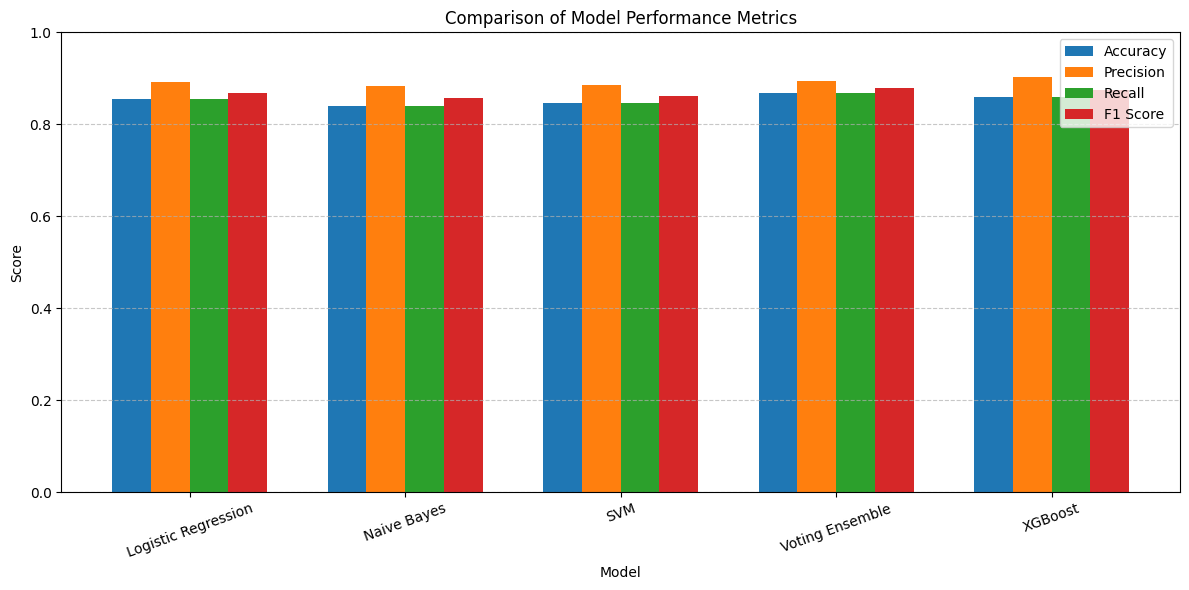

In [ ]:
# Set figure size and style
plt.figure(figsize=(12, 6))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bar_width = 0.18
x = range(len(metrics_df))

# Plot each metric as a group of bars
for i, metric in enumerate(metrics_to_plot):
    plt.bar([p + i * bar_width for p in x], metrics_df[metric], width=bar_width, label=metric)

# Configure x-axis
plt.xticks([p + 1.5 * bar_width for p in x], metrics_df['Model'], rotation=20)
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Comparison of Model Performance Metrics')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## 6. Preparing Dataset, Training and Evaluating Deep Learning Models

In [39]:
!pip install torchtext --quiet

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip -P /content/drive/MyDrive/
!unzip /content/drive/MyDrive/glove.6B.zip -d /content/drive/MyDrive/

In [27]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Apply oversampling to text data (X_train, y_train)
ros = RandomOverSampler(random_state=42)
# Reshape X_train to 2D array for oversampling
X_train_reshaped = X_train.values.reshape(-1, 1)
X_train_resampled_text, y_train_resampled = ros.fit_resample(X_train_reshaped, y_train)

# Convert back to Series for consistency
X_train_resampled_text = pd.Series(X_train_resampled_text.flatten(), name='cleaned_tweet')
y_train_resampled = pd.Series(y_train_resampled, name='class')

# Show class distribution before and after oversampling
print("Before Oversampling (Text Data):")
print(pd.Series(y_train).value_counts())
print("\nAfter Oversampling (Text Data):")
print(pd.Series(y_train_resampled).value_counts())

Before Oversampling (Text Data):
class
1    15352
2     3330
0     1144
Name: count, dtype: int64

After Oversampling (Text Data):
class
1    15352
2    15352
0    15352
Name: count, dtype: int64


### 6.1. LSTM (Long Short Term Memory)

In [28]:
import os

# Define PyTorch Dataset for LSTM
class TweetDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=50):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx] if hasattr(self.texts, 'iloc') else self.texts[idx]
        label = self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx]
        tokens = text.split()[:self.max_len]
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        indices = indices + [0] * (self.max_len - len(indices))  # Padding
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [29]:
# Function to load GloVe embeddings manually
def load_glove_embeddings(glove_path, vocab, embed_dim=100):
    embedding_matrix = torch.zeros((len(vocab), embed_dim))
    if not os.path.exists(glove_path):
        raise FileNotFoundError(f"GloVe file not found at {glove_path}. Please download glove.6B.100d.txt.")
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            if word in vocab:
                vector = torch.tensor([float(x) for x in parts[1:]], dtype=torch.float)
                embedding_matrix[vocab[word]] = vector
    return embedding_matrix

# Build vocabulary
def build_vocab(texts):
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {word: idx+2 for idx, (word, _) in enumerate(counter.most_common())}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1
    return vocab

In [30]:
# Prepare data
glove_path = '/content/drive/MyDrive/glove.6B.100d.txt'
vocab = build_vocab(X_train_resampled_text)
embedding_matrix = load_glove_embeddings(glove_path, vocab, embed_dim=100)
train_dataset = TweetDataset(X_train_resampled_text, y_train_resampled, vocab, max_len=50)
test_dataset = TweetDataset(X_test, y_test, vocab, max_len=50)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print("LSTM Data Preparation Complete")
print(f"Vocabulary Size: {len(vocab)}")
print(f"Embedding Matrix Shape: {embedding_matrix.shape}")
print(f"Train Loader Size: {len(train_loader)} batches")
print(f"Test Loader Size: {len(test_loader)} batches")

LSTM Data Preparation Complete
Vocabulary Size: 15059
Embedding Matrix Shape: torch.Size([15059, 100])
Train Loader Size: 1440 batches
Test Loader Size: 155 batches


In [31]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(self.dropout(hidden))

# Training function
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model = model.to(device)
    best_f1 = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"LSTM Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}")
        # Validation on training data (for simplicity)
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"LSTM Validation F1: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), '/content/drive/MyDrive/lstm_model.pt')


In [32]:
# Evaluation function
def evaluate_model(model, test_loader, device, model_name):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_preds = torch.argmax(outputs, dim=1)
            preds.extend(batch_preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(true_labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')
    print(f"\n{model_name} Test Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{classification_report(true_labels, preds, target_names=['Hate Speech', 'Offensive', 'Neither'])}")
    return {'Model': model_name, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

In [35]:
# Main execution for LSTM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTMClassifier(vocab_size=len(vocab), embed_dim=100, hidden_dim=128, num_classes=3).to(device)
lstm_model.embedding.weight.data.copy_(embedding_matrix)
lstm_model.embedding.weight.requires_grad = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)

# Train and evaluate
train_model(lstm_model, train_loader, criterion, optimizer, device, epochs=20)
lstm_metrics = evaluate_model(lstm_model, test_loader, device, 'LSTM')
metrics = []
metrics.append(lstm_metrics)

print("LSTM Training and Evaluation Complete")

LSTM Epoch 1, Train Loss: 0.5475
LSTM Validation F1: 0.8501
LSTM Epoch 2, Train Loss: 0.3336
LSTM Validation F1: 0.9149
LSTM Epoch 3, Train Loss: 0.2225
LSTM Validation F1: 0.9416
LSTM Epoch 4, Train Loss: 0.1609
LSTM Validation F1: 0.9646
LSTM Epoch 5, Train Loss: 0.1183
LSTM Validation F1: 0.9721
LSTM Epoch 6, Train Loss: 0.0946
LSTM Validation F1: 0.9796
LSTM Epoch 7, Train Loss: 0.0725
LSTM Validation F1: 0.9860
LSTM Epoch 8, Train Loss: 0.0629
LSTM Validation F1: 0.9887
LSTM Epoch 9, Train Loss: 0.0540
LSTM Validation F1: 0.9872
LSTM Epoch 10, Train Loss: 0.0473
LSTM Validation F1: 0.9912
LSTM Epoch 11, Train Loss: 0.0400
LSTM Validation F1: 0.9909
LSTM Epoch 12, Train Loss: 0.0399
LSTM Validation F1: 0.9914
LSTM Epoch 13, Train Loss: 0.0340
LSTM Validation F1: 0.9921
LSTM Epoch 14, Train Loss: 0.0317
LSTM Validation F1: 0.9947
LSTM Epoch 15, Train Loss: 0.0359
LSTM Validation F1: 0.9923
LSTM Epoch 16, Train Loss: 0.0247
LSTM Validation F1: 0.9922
LSTM Epoch 17, Train Loss: 0.0301

### 6.2. GRU (Gated Recurrent Units)

In [36]:
# Define GRU Model
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=1, dropout=0.3):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(self.dropout(hidden))

# Training function
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model = model.to(device)
    best_f1 = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"GRU Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}")
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"GRU Validation F1: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), '/content/drive/MyDrive/gru_model.pt')

In [37]:
# Evaluation function
def evaluate_model(model, test_loader, device, model_name):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_preds = torch.argmax(outputs, dim=1)
            preds.extend(batch_preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(true_labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')
    print(f"\n{model_name} Test Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{classification_report(true_labels, preds, target_names=['Hate Speech', 'Offensive', 'Neither'])}")
    return {'Model': model_name, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

In [39]:
# Main execution for GRU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_model = GRUClassifier(vocab_size=len(vocab), embed_dim=100, hidden_dim=128, num_classes=3).to(device)
gru_model.embedding.weight.data.copy_(embedding_matrix)
gru_model.embedding.weight.requires_grad = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_model.parameters(), lr=1e-3)

# Train and evaluate
train_model(gru_model, train_loader, criterion, optimizer, device, epochs=20)
gru_metrics = evaluate_model(gru_model, test_loader, device, 'GRU')
metrics.append(gru_metrics)

print("GRU Training and Evaluation Complete")

GRU Epoch 1, Train Loss: 0.5294
GRU Validation F1: 0.8209
GRU Epoch 2, Train Loss: 0.3168
GRU Validation F1: 0.9239
GRU Epoch 3, Train Loss: 0.2003
GRU Validation F1: 0.9564
GRU Epoch 4, Train Loss: 0.1427
GRU Validation F1: 0.9721
GRU Epoch 5, Train Loss: 0.1040
GRU Validation F1: 0.9781
GRU Epoch 6, Train Loss: 0.0807
GRU Validation F1: 0.9805
GRU Epoch 7, Train Loss: 0.0657
GRU Validation F1: 0.9870
GRU Epoch 8, Train Loss: 0.0539
GRU Validation F1: 0.9902
GRU Epoch 9, Train Loss: 0.0487
GRU Validation F1: 0.9899
GRU Epoch 10, Train Loss: 0.0456
GRU Validation F1: 0.9913
GRU Epoch 11, Train Loss: 0.0426
GRU Validation F1: 0.9925
GRU Epoch 12, Train Loss: 0.0393
GRU Validation F1: 0.9903
GRU Epoch 13, Train Loss: 0.0340
GRU Validation F1: 0.9929
GRU Epoch 14, Train Loss: 0.0346
GRU Validation F1: 0.9923
GRU Epoch 15, Train Loss: 0.0340
GRU Validation F1: 0.9884
GRU Epoch 16, Train Loss: 0.0325
GRU Validation F1: 0.9936
GRU Epoch 17, Train Loss: 0.0320
GRU Validation F1: 0.9916
GRU Ep

### 6.3. CNN (Convolutional Neural Networks)

In [41]:
# Define CNN Model
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, filter_sizes, num_classes, dropout=0.3):
        super(CNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # 1D convolutional layers for different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        embedded = embedded.permute(0, 2, 1)  # [batch_size, embed_dim, seq_len]
        # Apply convolutions and max-pooling
        conved = [self.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]  # Max-over-time pooling
        cat = self.dropout(torch.cat(pooled, dim=1))  # Concatenate pooled features
        return self.fc(cat)

# Training function
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model = model.to(device)
    best_f1 = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"CNN Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}")
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"CNN Validation F1: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), '/content/drive/MyDrive/cnn_model.pt')

In [42]:
# Evaluation function
def evaluate_model(model, test_loader, device, model_name):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_preds = torch.argmax(outputs, dim=1)
            preds.extend(batch_preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(true_labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')
    print(f"\n{model_name} Test Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{classification_report(true_labels, preds, target_names=['Hate Speech', 'Offensive', 'Neither'])}")
    return {'Model': model_name, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

In [43]:
# Main execution for CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = CNNClassifier(
    vocab_size=len(vocab),
    embed_dim=100,
    num_filters=100,
    filter_sizes=[2, 3, 4],
    num_classes=3,
    dropout=0.3
).to(device)
cnn_model.embedding.weight.data.copy_(embedding_matrix)
cnn_model.embedding.weight.requires_grad = False  # Freeze embeddings
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

# Train and evaluate
train_model(cnn_model, train_loader, criterion, optimizer, device, epochs=20)
cnn_metrics = evaluate_model(cnn_model, test_loader, device, 'CNN')
metrics.append(cnn_metrics)

print("CNN Training and Evaluation Complete")

CNN Epoch 1, Train Loss: 0.4266
CNN Validation F1: 0.9245
CNN Epoch 2, Train Loss: 0.2278
CNN Validation F1: 0.9607
CNN Epoch 3, Train Loss: 0.1675
CNN Validation F1: 0.9690
CNN Epoch 4, Train Loss: 0.1342
CNN Validation F1: 0.9798
CNN Epoch 5, Train Loss: 0.1138
CNN Validation F1: 0.9853
CNN Epoch 6, Train Loss: 0.1025
CNN Validation F1: 0.9870
CNN Epoch 7, Train Loss: 0.0926
CNN Validation F1: 0.9866
CNN Epoch 8, Train Loss: 0.0852
CNN Validation F1: 0.9899
CNN Epoch 9, Train Loss: 0.0769
CNN Validation F1: 0.9914
CNN Epoch 10, Train Loss: 0.0744
CNN Validation F1: 0.9894
CNN Epoch 11, Train Loss: 0.0711
CNN Validation F1: 0.9907
CNN Epoch 12, Train Loss: 0.0682
CNN Validation F1: 0.9910
CNN Epoch 13, Train Loss: 0.0664
CNN Validation F1: 0.9919
CNN Epoch 14, Train Loss: 0.0657
CNN Validation F1: 0.9925
CNN Epoch 15, Train Loss: 0.0585
CNN Validation F1: 0.9902
CNN Epoch 16, Train Loss: 0.0596
CNN Validation F1: 0.9937
CNN Epoch 17, Train Loss: 0.0577
CNN Validation F1: 0.9930
CNN Ep

## 7. Comparison of Performance of Deep Learning Models

In [51]:
metrics_df = pd.DataFrame(metrics)

metrics_df = metrics_df.sort_values(by='F1 Score', ascending=False)

metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']] = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].round(4)

print("\nEvaluation Metrics for All Models (Sorted by F1 Score):")
print("-" * 60)
print(metrics_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].to_string(index=False))
print("-" * 60)


Evaluation Metrics for All Models (Sorted by F1 Score):
------------------------------------------------------------
Model  Accuracy  Precision  Recall  F1 Score
  CNN    0.8545     0.8582  0.8545    0.8560
  GRU    0.8570     0.8543  0.8570    0.8550
 LSTM    0.8564     0.8530  0.8564    0.8545
------------------------------------------------------------


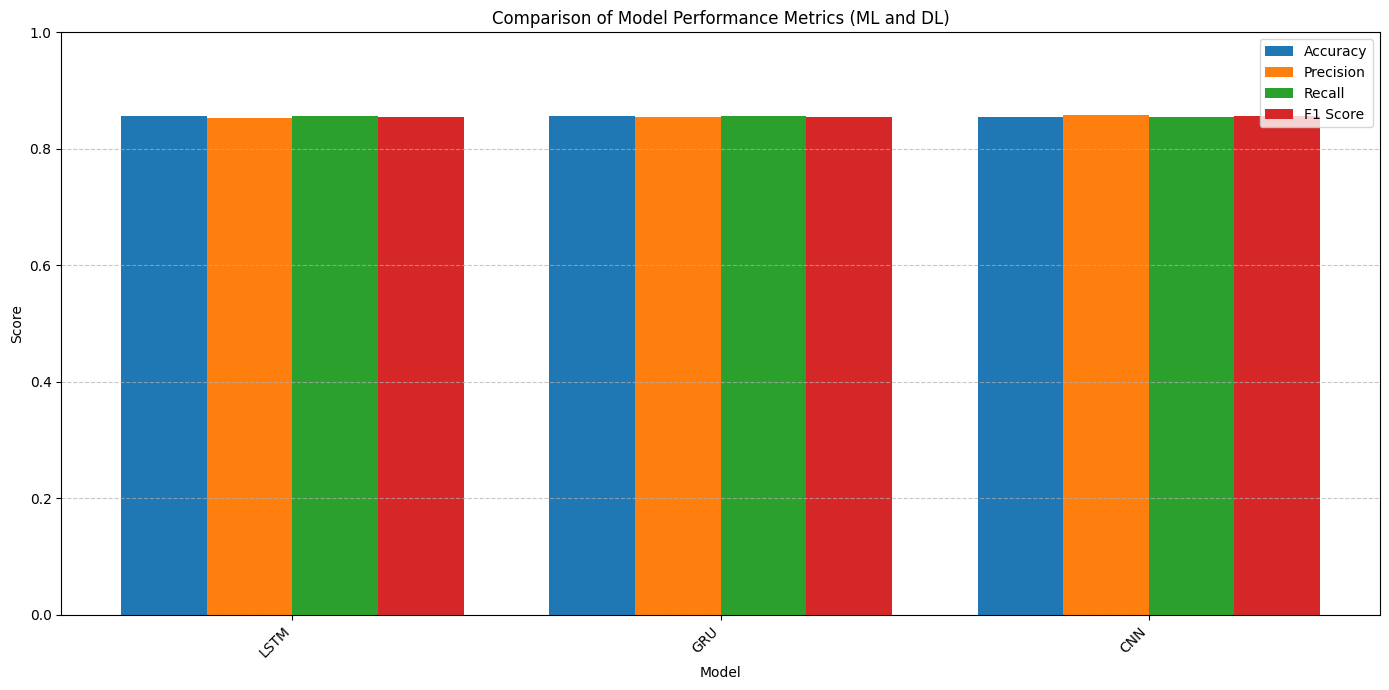

In [52]:
metrics_df = pd.DataFrame(metrics)

# Plot metrics
plt.figure(figsize=(14, 7))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bar_width = 0.2
x = range(len(metrics_df))

for i, metric in enumerate(metrics_to_plot):
    plt.bar([p + i * bar_width for p in x], metrics_df[metric], width=bar_width, label=metric)

plt.xticks([p + 1.5 * bar_width for p in x], metrics_df['Model'], rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Comparison of Model Performance Metrics (ML and DL)')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 8. Inference (Voting Classifier)

In [7]:
# Define preprocessing functions
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text, stop_words):
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

def stem_text(text, stemmer):
    tokens = text.split()
    stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed)

# Initialize preprocessing components
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Apply preprocessing to the dataset
df['cleaned_tweet'] = df['tweet'].apply(clean_text)
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: remove_stopwords(x, stop_words))
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: stem_text(x, stemmer))

# Split the data
X = df['cleaned_tweet']
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and apply vectorizer
vectorizer = CountVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Apply oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vec, y_train)

# Show class distribution
print("Before Oversampling:")
print(pd.Series(y_train).value_counts())
print("\nAfter Oversampling:")
print(pd.Series(y_train_resampled).value_counts())

Before Oversampling:
class
1    15358
2     3328
0     1140
Name: count, dtype: int64

After Oversampling:
class
0    15358
2    15358
1    15358
Name: count, dtype: int64


In [ ]:
import joblib

# Define individual classifiers
log_reg = LogisticRegression(max_iter=1000, random_state=42)
nb = MultinomialNB()
svm = SVC(kernel='linear', probability=True, random_state=42)

# Define Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('nb', nb), ('svm', svm)],
    voting='soft'
)

# Train Voting Classifier
voting_clf.fit(X_train_resampled, y_train_resampled)

print("Voting Classifier Training Complete")
print("Model, vectorizer, stopwords, and stemmer saved to Google Drive")

Voting Classifier Training Complete
Model, vectorizer, stopwords, and stemmer saved to Google Drive


In [9]:
y_pred = voting_clf.predict(X_test_vec)

acc = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

In [10]:
print("\nVoting Classifier Test Results:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Voting Classifier Test Results:
Accuracy: 0.8594
Precision: 0.8869
Recall: 0.8594
F1 Score: 0.8705
